#### Imports

In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt

# Exercises

In [2]:
df = pd.read_csv('saas.csv')

In [3]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [4]:
df.shape

(790458, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [7]:
df.columns = df.columns.str.lower()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   month_invoiced     790458 non-null  object 
 1   customer_id        790458 non-null  int64  
 2   invoice_id         790458 non-null  int64  
 3   subscription_type  790458 non-null  float64
 4   amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [10]:
df.month_invoiced = df.month_invoiced.astype('datetime64')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   month_invoiced     790458 non-null  datetime64[ns]
 1   customer_id        790458 non-null  int64         
 2   invoice_id         790458 non-null  int64         
 3   subscription_type  790458 non-null  float64       
 4   amount             790458 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 30.2 MB


In [13]:
df = df.set_index('month_invoiced').sort_index()

In [14]:
df

,customer_id,invoice_id,subscription_type,amount
month_invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0
...,...,...,...,...
2017-12-31,1029395,5790453,0.0,0.0
2017-12-31,1029396,5790454,0.0,0.0
2017-12-31,1029397,5790455,3.0,15.0


In [18]:
df.describe()

,customer_id,invoice_id,subscription_type,amount
count,7.904580e+05,7.904580e+05,790458.000000,790458.000000
mean,1.012913e+06,5.395228e+06,0.599235,2.996174
std,7.591992e+03,2.281857e+05,0.950380,4.751901
min,1.000000e+06,5.000000e+06,0.000000,0.000000
25%,1.006405e+06,5.197614e+06,0.000000,0.000000
50%,1.012797e+06,5.395228e+06,0.000000,0.000000
75%,1.019154e+06,5.592843e+06,1.000000,5.000000
max,1.029399e+06,5.790457e+06,4.000000,20.000000


In [36]:
df_resampled = df.resample('M')[['amount']].sum()

In [37]:
df_resampled.head()

,amount
month_invoiced,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


In [44]:
df_resampled.shape

(48, 1)

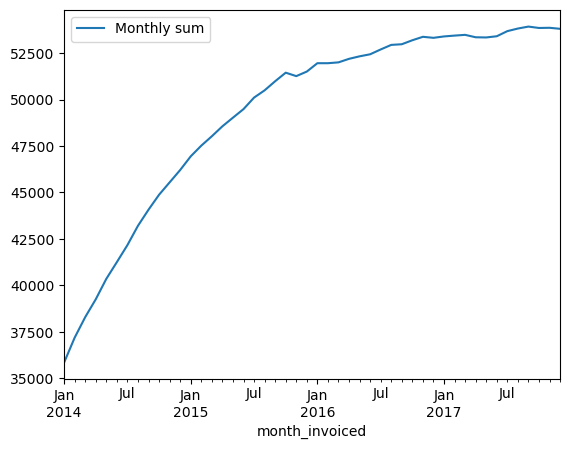

In [33]:
# df.resample('W').amount.sum().plot(label='Weekly sum')
df.resample('M').amount.sum().plot(label='Monthly sum')
# df.resample('Q').amount.sum().plot(label='Quarterly sum')
# df.resample('Y').amount.sum().plot(label='Yearly sum')
plt.legend()

#### 1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [38]:
.5 * df_resampled.shape[0]

24.0

In [39]:
int(.5 * len(df_resampled))

24

In [40]:
train_size = int(.5 * len(df_resampled))

validate_size = int(len(df_resampled) * .3)

test_size = int(len(df_resampled) - train_size - validate_size)

validate_end_index = train_size + validate_size

train = df_resampled[:train_size]
validate = df_resampled[train_size:validate_end_index]
test = df_resampled[validate_end_index:]

In [41]:
train.shape, validate.shape, test.shape

((24, 1), (14, 1), (10, 1))

In [42]:
train.shape[0] + validate.shape[0] + test.shape[0]

48

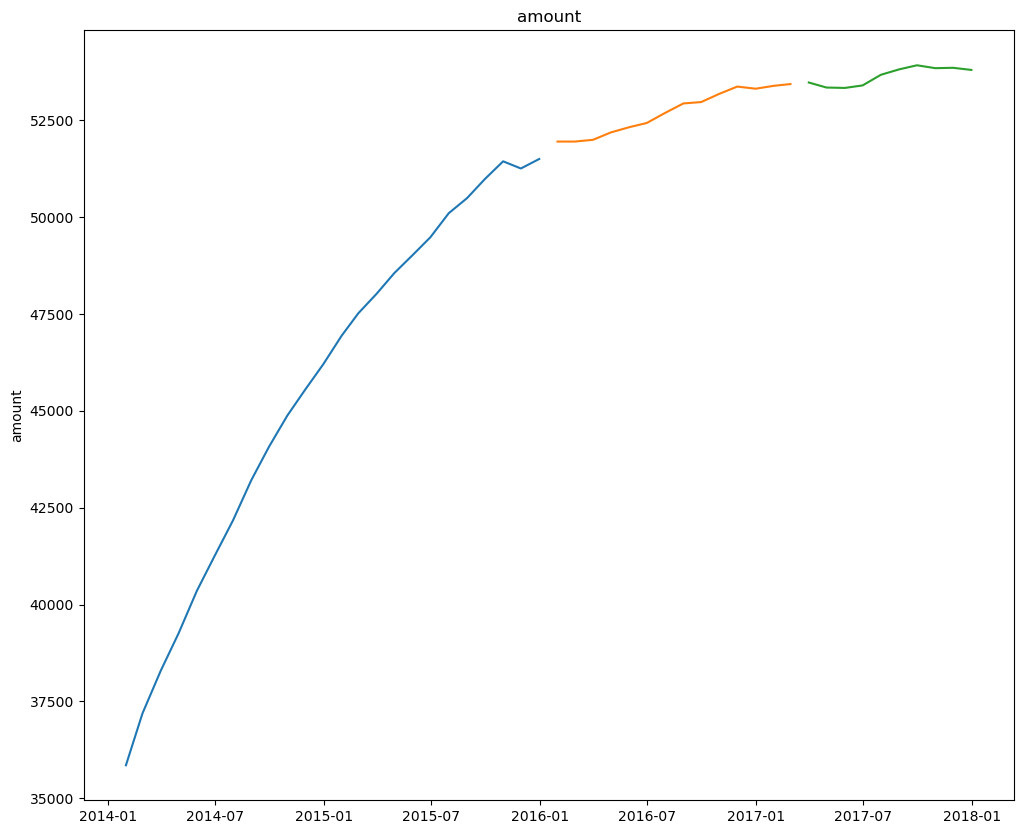

In [43]:
for col in train.columns:
    plt.figure(figsize=(12,10))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

#### 2. Forecast, plot and evaluate using each at least 4 of the methods we discussed:
   - Last Observed Value
   - Simple Average
   - Moving Average
   - Holt's Linear Trend
   - Holt's Seasonal Trend
   - Based on previous year/month/etc., this is up to you.

In [45]:
def evaluate(target_var):
    '''
    
    '''
    
    rmse = round(
        sqrt(
            mean_squared_error(
            validate[target_var],
            yhat_df[target_var])
        ), 0)
    return rmse

In [46]:
def plot_and_eval(target_var):
    '''
    
    '''
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var], label='Prediction', linewidth=1)
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, f'-- rmse: {round(rmse,2)}')
    plt.legend()
    plt.show()

In [47]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [48]:
def append_eval_df(model_type, target_var):
    '''
    
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    return pd.concat([eval_df, pd.DataFrame(d)])

#### Last observed Value

In [54]:
train['amount'][-1]

51505.0

In [56]:
last_sales = train['amount'][-1]

yhat_df = pd.DataFrame(
    {
        'amount': [last_sales]
    },
    index = validate.index
)

In [57]:
yhat_df.head()

,amount
month_invoiced,
2016-01-31,51505.0
2016-02-29,51505.0
2016-03-31,51505.0
2016-04-30,51505.0
2016-05-31,51505.0


amount -- rmse: 1343.0


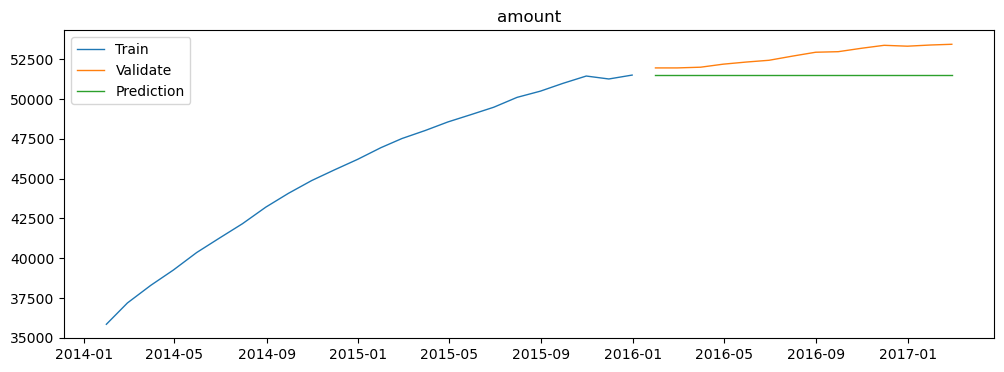

In [58]:
for col in train.columns:
    plot_and_eval(col)

In [59]:
eval_df

,model_type,target_var,rmse


In [60]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value',
                            target_var=col)

In [61]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0


#### Simple Average

In [63]:
avg_sales = round(train['amount'].mean(), 2)

yhat_df = pd.DataFrame({'amount': [avg_sales]},
                      index=validate.index)
yhat_df.head(3)

,amount
month_invoiced,
2016-01-31,45568.54
2016-02-29,45568.54
2016-03-31,45568.54


amount -- rmse: 7181.0


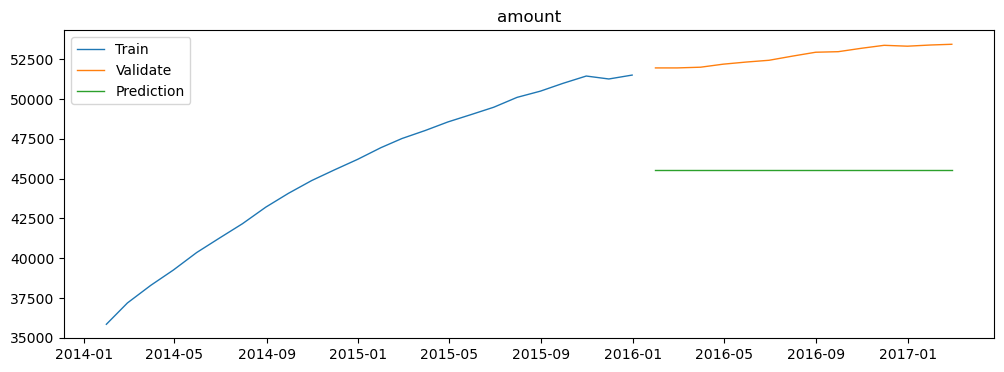

In [64]:
for col in train.columns:
    plot_and_eval(col)

In [65]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average',
                            target_var= col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
0,simple_average,amount,7181.0


#### Holt-Winters

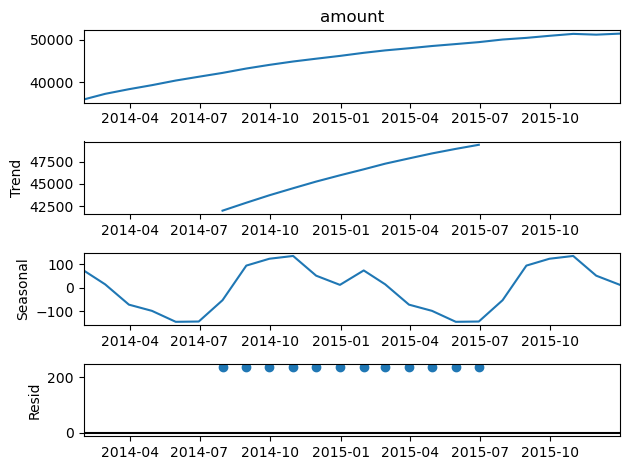

In [68]:
for col in train.columns:
    sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()

In [69]:
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_values = model.predict(start=validate.index[0],
                               end=validate.index[-1])
    yhat_df[col] = round(yhat_values, 2)

In [70]:
yhat_df.head()

,amount
month_invoiced,
2016-01-31,51748.62
2016-02-29,51962.00
2016-03-31,52173.35
2016-04-30,52382.69
2016-05-31,52590.04


amount -- rmse: 456.0


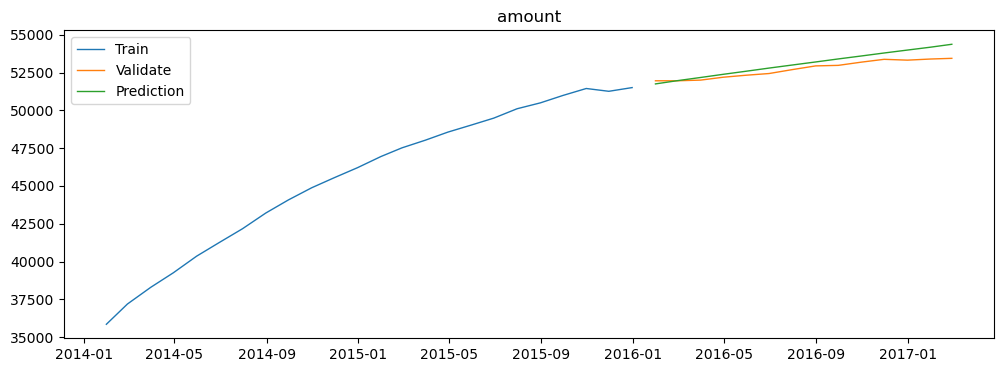

In [71]:
for col in train.columns:
    plot_and_eval(target_var= col)

In [72]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized',
                            target_var= col)

In [73]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
0,simple_average,amount,7181.0
0,holts_optimized,amount,456.0


#### Previous Cycle